In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

from modules import *
from networks import *
from training import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
size = 256
transform = A.Compose([
    A.Resize(height=size, width=size, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

In [ ]:
best_model_path = "../models/polar/ref/dual.pth"
checkpoint = load_checkpoint(best_model_path, map_location=device)
model = checkpoint['model']
model = model.eval()

In [4]:
def load_origa_dataframe():
    origa_df = pd.read_excel('../data/ORIGA/labels.xlsx')
    origa_df['filename'] = origa_df['filename'].str.strip().str.strip("'")
    origa_df = origa_df.rename(columns={'diagnosis(glaucoma=True)': 'glaucoma'})
    origa_df = origa_df[['filename', 'glaucoma']]
    origa_df = origa_df.dropna()
    return origa_df


def load_drishti_dataframe():
    drishti_df = pd.read_excel('../data/DRISHTI/Drishti-GS1_files/Drishti-GS1_diagnosis.xlsx')
    drishti_df = drishti_df.rename(columns={'Unnamed: 1': 'filename', 'Unnamed: 8': 'glaucoma'})
    drishti_df['filename'] = drishti_df['filename'].str.strip().str.strip("'")
    drishti_df['glaucoma'] = drishti_df['glaucoma'].map({'Glaucomatous': True, 'Normal': False})
    drishti_df = drishti_df[['filename', 'glaucoma']]
    drishti_df = drishti_df.dropna()
    return drishti_df

In [ ]:
def generate_dataframe(images_root: str, masks_root: str):
    image_paths = load_files_from_dir(images_root)
    mask_paths = load_files_from_dir(masks_root)
    df = load_origa_dataframe() if 'ORIGA' in images_root else load_drishti_dataframe()

    rows = []
    for image_path, mask_path in zip(tqdm(image_paths), mask_paths):
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        real_vcdr = calculate_vCDR(mask)
        real_hcdr = calculate_hCDR(mask)
        real_acdr = calculate_aCDR(mask)
        real_disc_height = calculate_disc_height(mask)
        real_disc_width = calculate_disc_width(mask)
        real_disc_area = calculate_disc_area(mask)
        read_cup_height = calculate_cup_height(mask)
        real_cup_width = calculate_cup_width(mask)
        real_cup_area = calculate_cup_area(mask)

        augmented = transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        images = image.unsqueeze(0).to(device)
        masks = mask.unsqueeze(0).to(device)

        prediction, *_ = predict(
            'dual', model, images, masks, device=device,
            od_thresh=0.20, oc_thresh=0.25, post_process_fn=postprocess,
        )

        prediction = prediction.cpu().numpy().astype(np.uint8)
        prediction = polar_to_cartesian(prediction)[0]

        pred_vcdr = calculate_vCDR(prediction)
        pred_hcdr = calculate_hCDR(prediction)
        pred_acdr = calculate_aCDR(prediction)
        pred_disc_height = calculate_disc_height(prediction)
        pred_disc_width = calculate_disc_width(prediction)
        pred_disc_area = calculate_disc_area(prediction)
        pred_cup_height = calculate_cup_height(prediction)
        pred_cup_width = calculate_cup_width(prediction)
        pred_cup_area = calculate_cup_area(prediction)

        subset = f'{"origa" if "ORIGA" in image_path else "drishti"}_{"train" if "Train" in image_path else "test"}'
        row = df[df['filename'].str.contains(Path(image_path).stem)]
        assert len(row) == 1, f"Found {len(row)} rows for {image_path}"

        rows.append({
            'image': image_path,
            'mask': mask_path,
            'set': subset,
            'glaucoma': row['glaucoma'].values[0],
            'real_vcdr': real_vcdr,
            'pred_vcdr': pred_vcdr,
            'real_hcdr': real_hcdr,
            'pred_hcdr': pred_hcdr,
            'real_acdr': real_acdr,
            'pred_acdr': pred_acdr,
            'real_disc_height': real_disc_height,
            'pred_disc_height': pred_disc_height,
            'real_disc_width': real_disc_width,
            'pred_disc_width': pred_disc_width,
            'real_disc_area': real_disc_area,
            'pred_disc_area': pred_disc_area,
            'real_cup_height': read_cup_height,
            'pred_cup_height': pred_cup_height,
            'real_cup_width': real_cup_width,
            'pred_cup_width': pred_cup_width,
            'real_cup_area': real_cup_area,
            'pred_cup_area': pred_cup_area,
        })

    return pd.DataFrame(rows)


origa_train_df = generate_dataframe('../data/ORIGA/ROI/TrainImages', '../data/ORIGA/ROI/TrainMasks')
origa_test_df = generate_dataframe('../data/ORIGA/ROI/TestImages', '../data/ORIGA/ROI/TestMasks')
drishti_train_df = generate_dataframe('../data/DRISHTI/ROI/TrainImages', '../data/DRISHTI/ROI/TrainMasks')
drishti_test_df = generate_dataframe('../data/DRISHTI/ROI/TestImages', '../data/DRISHTI/ROI/TestMasks')

In [26]:
df = pd.concat([
    origa_train_df,
    origa_test_df,
    drishti_train_df,
    drishti_test_df,
])
df.to_csv('../data/cdr-results.csv', index=False)
df

,image,mask,real_vcdr,pred_vcdr,real_hcdr,pred_hcdr,set,glaucoma
0,../data/ORIGA/ROI/TrainImages/001.jpg,../data/ORIGA/ROI/TrainMasks/001.png,0.711409,0.684932,0.670782,0.750000,origa_train,False
1,../data/ORIGA/ROI/TrainImages/002.jpg,../data/ORIGA/ROI/TrainMasks/002.png,0.693431,0.657143,0.711009,0.672566,origa_train,False
2,../data/ORIGA/ROI/TrainImages/003.jpg,../data/ORIGA/ROI/TrainMasks/003.png,0.964286,0.774834,0.955556,0.745342,origa_train,False
3,../data/ORIGA/ROI/TrainImages/004.jpg,../data/ORIGA/ROI/TrainMasks/004.png,0.723549,0.657143,0.715953,0.707692,origa_train,False
4,../data/ORIGA/ROI/TrainImages/005.jpg,../data/ORIGA/ROI/TrainMasks/005.png,0.613445,0.663866,0.736842,0.732759,origa_train,False
...,...,...,...,...,...,...,...,...
46,../data/DRISHTI/ROI/TestImages/drishtiGS_095.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_095.png,0.503817,0.553030,0.490119,0.606557,drishti_test,False
47,../data/DRISHTI/ROI/TestImages/drishtiGS_096.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_096.png,0.510345,0.534591,0.460432,0.601399,drishti_test,False
48,../data/DRISHTI/ROI/TestImages/drishtiGS_097.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_097.png,0.525424,0.682635,0.574924,0.644578,drishti_test,False
49,../data/DRISHTI/ROI/TestImages/drishtiGS_099.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_099.png,0.627586,0.703947,0.626374,0.730496,drishti_test,False


In [6]:
df = pd.read_csv('../data/cdr-results.csv')
df_train = df[~(df['set'].str.contains('test') & df['set'].str.contains('drishti'))]
df_test = df[df['set'].str.contains('test') & df['set'].str.contains('drishti')]
print(f'Train: {len(df_train)} | Test: {len(df_test)} | Total: {len(df)}')
df

Train: 700 | Test: 51 | Total: 751


,image,mask,real_vcdr,pred_vcdr,real_hcdr,pred_hcdr,set,glaucoma
0,../data/ORIGA/ROI/TrainImages/001.jpg,../data/ORIGA/ROI/TrainMasks/001.png,0.711409,0.684932,0.670782,0.750000,origa_train,False
1,../data/ORIGA/ROI/TrainImages/002.jpg,../data/ORIGA/ROI/TrainMasks/002.png,0.693431,0.657143,0.711009,0.672566,origa_train,False
2,../data/ORIGA/ROI/TrainImages/003.jpg,../data/ORIGA/ROI/TrainMasks/003.png,0.964286,0.774834,0.955556,0.745342,origa_train,False
3,../data/ORIGA/ROI/TrainImages/004.jpg,../data/ORIGA/ROI/TrainMasks/004.png,0.723549,0.657143,0.715953,0.707692,origa_train,False
4,../data/ORIGA/ROI/TrainImages/005.jpg,../data/ORIGA/ROI/TrainMasks/005.png,0.613445,0.663866,0.736842,0.732759,origa_train,False
...,...,...,...,...,...,...,...,...
746,../data/DRISHTI/ROI/TestImages/drishtiGS_095.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_095.png,0.503817,0.553030,0.490119,0.606557,drishti_test,False
747,../data/DRISHTI/ROI/TestImages/drishtiGS_096.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_096.png,0.510345,0.534591,0.460432,0.601399,drishti_test,False
748,../data/DRISHTI/ROI/TestImages/drishtiGS_097.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_097.png,0.525424,0.682635,0.574924,0.644578,drishti_test,False
749,../data/DRISHTI/ROI/TestImages/drishtiGS_099.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_099.png,0.627586,0.703947,0.626374,0.730496,drishti_test,False


MAE: 0.05625853068535328
MSE: 0.00569406859204489
R^2: 0.6668212740976481


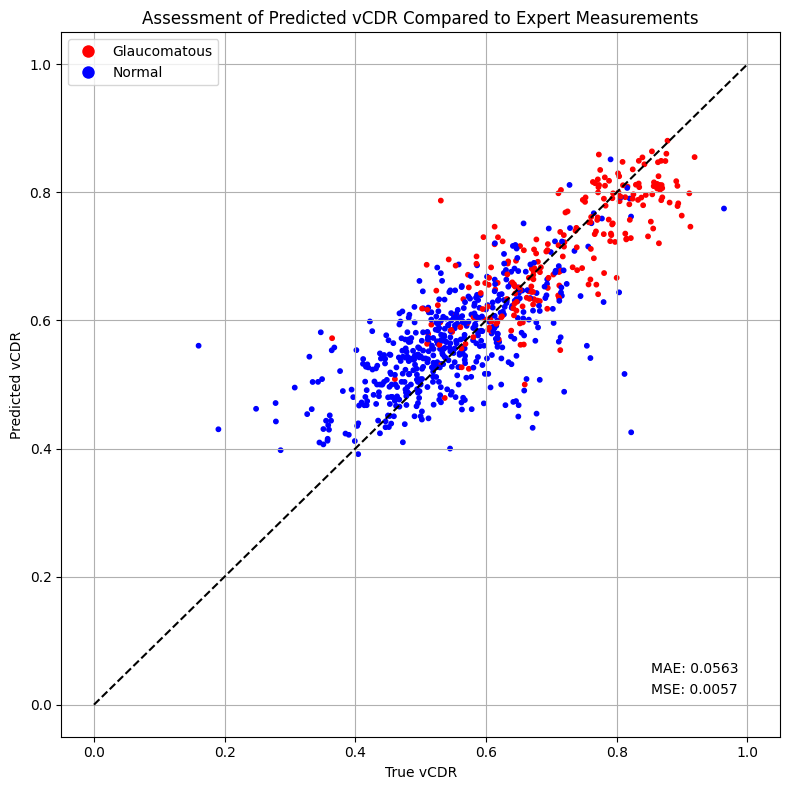

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

true = df['real_vcdr']
pred = df['pred_vcdr']
glaucoma = df['glaucoma']

print('MAE:', mean_absolute_error(true, pred))
print('MSE:', mean_squared_error(true, pred))
print('R^2:', r2_score(true, pred))

colors = glaucoma.map({True: 'red', False: 'blue'})

plt.figure(figsize=(8, 8))
plt.scatter(true, pred, c=colors, s=10, label=glaucoma.map({True: 'Glaucoma', False: 'Non-Glaucoma'}))
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('True vCDR')
plt.ylabel('Predicted vCDR')
plt.title('Assessment of Predicted vCDR Compared to Expert Measurements')
plt.grid()
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Glaucomatous', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10),
])
plt.tight_layout()
plt.text(0.82, 0.09, f'MAE: {mean_absolute_error(true, pred):.4f}', transform=plt.gca().transAxes)
plt.text(0.82, 0.06, f'MSE: {mean_squared_error(true, pred):.4f}', transform=plt.gca().transAxes)
plt.show()

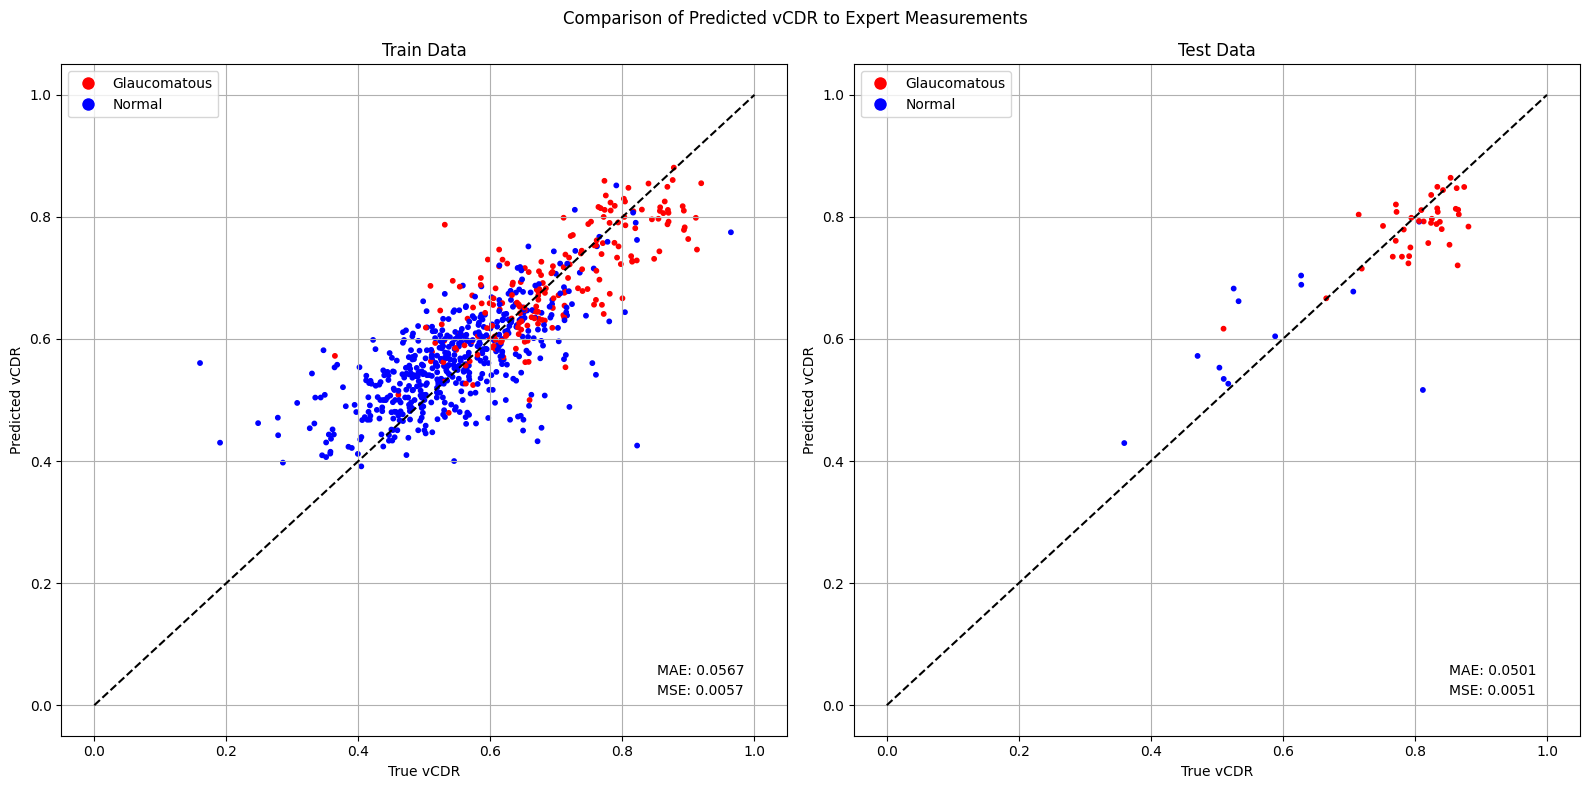

In [4]:
# Same plot but side by side with train and test data
true_train = df_train['real_vcdr']
pred_train = df_train['pred_vcdr']
glaucoma_train = df_train['glaucoma']

true_test = df_test['real_vcdr']
pred_test = df_test['pred_vcdr']
glaucoma_test = df_test['glaucoma']

_, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, true, pred, glaucoma, title in zip(
        axes,
        [true_train, true_test],
        [pred_train, pred_test],
        [glaucoma_train, glaucoma_test],
        ['Train', 'Test'],
):
    colors = glaucoma.map({True: 'red', False: 'blue'})
    ax.scatter(true, pred, c=colors, s=10, label=glaucoma.map({True: 'Glaucoma', False: 'Non-Glaucoma'}))
    ax.plot([0, 1], [0, 1], '--k')
    ax.set_xlabel('True vCDR')
    ax.set_ylabel('Predicted vCDR')
    ax.set_title(f'{title.capitalize()} Data')
    ax.grid()
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Glaucomatous', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10),
    ])
    ax.text(0.82, 0.09, f'MAE: {mean_absolute_error(true, pred):.4f}', transform=ax.transAxes)
    ax.text(0.82, 0.06, f'MSE: {mean_squared_error(true, pred):.4f}', transform=ax.transAxes)

plt.suptitle('Comparison of Predicted vCDR to Expert Measurements')
plt.tight_layout()
plt.show()

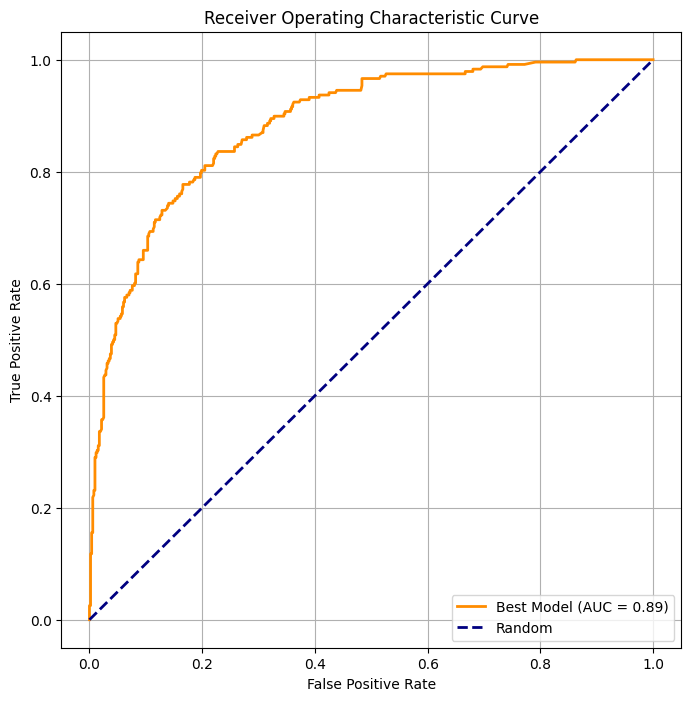

In [7]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df['glaucoma'], df['pred_vcdr'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Best Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Best Threshold: 0.63
Accuracy: 0.81
Sensitivity: 0.77
Specificity: 0.83


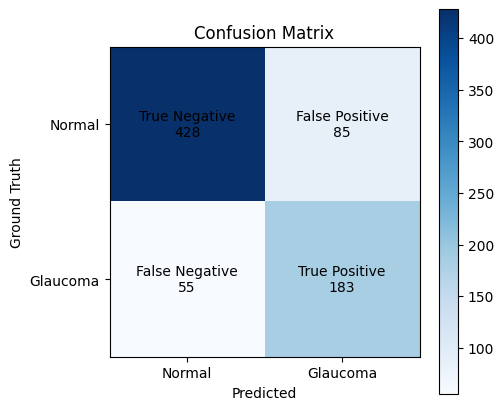

In [41]:
from sklearn.metrics import confusion_matrix

# Find best threshold anc calculate matrix
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f'Best Threshold: {best_threshold:.2f}')

distances_to_origin = np.sqrt(fpr ** 2 + (1 - tpr) ** 2)
best_threshold = thresholds[np.argmin(distances_to_origin)]
print(f'Best Threshold: {best_threshold:.2f}')

pred_glaucoma = df['pred_vcdr'] > best_threshold
true_glaucoma = df['glaucoma']

conf_matrix = confusion_matrix(true_glaucoma, pred_glaucoma)
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / len(df)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Glaucoma'])
plt.yticks([0, 1], ['Normal', 'Glaucoma'])
names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{names[i * 2 + j]}\n{conf_matrix[i, j]}', ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

Best Threshold: 0.63
Accuracy: 0.79
Sensitivity: 0.74
Specificity: 0.81


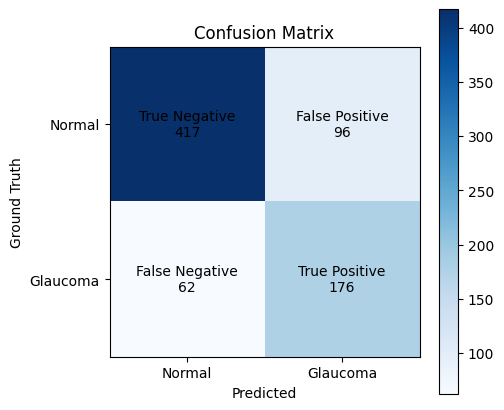

In [42]:
# Find best threshold anc calculate matrix
best_threshold = thresholds[np.argmax(tpr - fpr)]

pred_glaucoma = df['real_vcdr'] > best_threshold
true_glaucoma = df['glaucoma']

conf_matrix = confusion_matrix(true_glaucoma, pred_glaucoma)
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / len(df)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Glaucoma'])
plt.yticks([0, 1], ['Normal', 'Glaucoma'])
names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{names[i * 2 + j]}\n{conf_matrix[i, j]}', ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()